### Data loading, optmal model creation and saving

In [138]:
import pandas as pd
import numpy as np
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import xgboost as xgb
from ta import add_all_ta_features
import ta
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_log_error
import joblib
pd.set_option('display.max_columns', 1000)

def perform_trading_simulation(ticker, model_results, X_train, X_test, y_train, y_test):
    # Extract XGBoost parameters from results
    model_params = model_results['XGBoost'][0]
    # Initialize and train the XGBoost model
    model = XGBRegressor(**model_params)
    model.fit(X_train, y_train)

    # Generate predictions for all available data
    y_pred = model.predict(X_test)

    # Shift predictions by one to align with the next day's opening price in 'df'
    y_pred_shifted = np.roll(y_pred, -1)
    y_pred_shifted = y_pred_shifted[:-1]  # Remove the last prediction as it has no next day

    # Generate trading signals
    signals = ['Buy' if pred > open else 'Sell' for pred, open in zip(y_pred_shifted, X_test['Open'])]

    # Simulate trading
    initial_capital = 10000.00
    capital = initial_capital
    shares_owned = 0
    portfolio_value = []

    for i, (signal, actual_open, close) in enumerate(zip(signals, y_test, X_test['Open'])):
        if signal == 'Buy' and capital >= actual_open:
            shares_to_buy = int(capital // actual_open)
            capital -= shares_to_buy * actual_open
            shares_owned += shares_to_buy
        elif signal == 'Sell' and shares_owned > 0:
            capital += shares_owned * actual_open
            shares_owned = 0
        # Update the portfolio value based on current close prices
        portfolio_value.append(capital + shares_owned * close)

    # Finalize simulation
    if shares_owned > 0:
        capital += shares_owned * y_test.iloc[-1]
        shares_owned = 0

    return capital, portfolio_value

# Set the ticker symbol to be used
# ticker = 'GOOG'  

COMPANIES = ['MSFT', 'AAPL', 'NVDA', 'AMZN', 'GOOG', 'META', 'LLY', 'TSM', 'AVGO', 'V', 'NVO', 'TSLA', 'WMT', 'XOM', 'MA', 'UNH', 'ASML', 'JNJ', 'PG']
all_results = {}
results = {}
for ticker in COMPANIES:

    # Define the path to your file using the ticker variable
    file_path = f'Data/{ticker}_historical_data.csv'
    # Read the CSV file into a DataFrame
    df_prices = pd.read_csv(file_path)

    # Initialize lists to store data from all files
    all_dates, all_sentiment_scores, all_relevance_scores, all_avg_relevance_scores = [], [], [], []

    # List all JSON files in the directory corresponding to the ticker
    json_files = [file for file in os.listdir('Data') if file.startswith(f'{ticker}_news_data') and file.endswith('.json')]

    # Iterate over each JSON file
    for file in json_files:
        with open(os.path.join('Data', file), 'r', encoding='utf-8') as file:
            data = json.load(file)
            news_feed = data['feed']
        
        # Iterate over the news feed in each file to extract information
        for item in news_feed:
            ticker_info = [ts for ts in item['ticker_sentiment'] if ts['ticker'] == ticker]
            if ticker_info:  # Check if info is available in the ticker sentiment
                all_dates.append(item['time_published'])
                all_sentiment_scores.append(ticker_info[0]['ticker_sentiment_score'])
                all_relevance_scores.append(ticker_info[0]['relevance_score'])
                # Calculate the average relevance score for all tickers in the news item
                avg_relevance = sum(float(ts['relevance_score']) for ts in item['ticker_sentiment']) / len(item['ticker_sentiment'])
                all_avg_relevance_scores.append(avg_relevance)

        # Print length of lists after each file
        print(f"File: {file}, Entries: {len(all_dates)}")

    # Create a DataFrame from the collected data
    df = pd.DataFrame({
        'Date': all_dates,
        'Sentiment_Score': all_sentiment_scores,
        'Relevance_Score_ticker': all_relevance_scores,
        'Avg_Relevance_Score_topics': all_avg_relevance_scores
    })

    # Convert 'Date' column to datetime
    df['Date'] = pd.to_datetime(df['Date']).dt.normalize()

    # Convert relevant columns to float
    df['Sentiment_Score'] = df['Sentiment_Score'].astype(float)
    df['Relevance_Score_ticker'] = df['Relevance_Score_ticker'].astype(float)
    df['Avg_Relevance_Score_topics'] = df['Avg_Relevance_Score_topics'].astype(float)

    # Group by 'Date' and calculate mean, min, and max for 'Sentiment_Score'
    df_grouped = df.groupby('Date').agg({
        'Sentiment_Score': ['mean', 'min', 'max'],
        'Relevance_Score_ticker': 'mean',
        'Avg_Relevance_Score_topics': 'mean'
    }).reset_index()

    # Flatten multi-index columns
    df_grouped.columns = ['Date', 'Sentiment_Score_mean', 'Sentiment_Score_min', 'Sentiment_Score_max',
                        'Relevance_Score_ticker_mean', 'Avg_Relevance_Score_topics_mean']

    # Ensure df_grouped is loaded and has the necessary columns converted to datetime if not already done
    df_grouped['Date'] = pd.to_datetime(df_grouped['Date'])
    df_grouped.set_index('Date', inplace=True)

    # Create a date range from start date to end date
    date_range = pd.date_range(start='2023-08-31', end='2024-04-07', freq='D')

    # Reindex the DataFrame to include all dates in the range
    df_grouped = df_grouped.reindex(date_range)

    # Use backward fill to fill initial missing values, then forward fill the rest
    df_grouped.bfill(inplace=True)
    df_grouped.ffill(inplace=True)

    # Resetting index to turn 'Date' back into a column
    df_grouped.reset_index(inplace=True)
    df_grouped.rename(columns={'index': 'Date'}, inplace=True)

    df_prices['Date'] = df_prices['Date'].astype(str)
    # Slice the string to extract only the date part
    df_prices['Date'] = df_prices['Date'].str[0:10]
    # Convert back to datetime
    df_prices['Date'] = pd.to_datetime(df_prices['Date'])
    # Merge the data on 'Date'
    df1 = pd.merge(df_grouped, df_prices[['Date', 'Close', 'Open', 'Volume', 'Low', 'High']], on='Date', how='right')
    df = df1
    df['Next_Day_Open'] = df['Open'].shift(-1)
    df.dropna(subset='Next_Day_Open', inplace=True)
    df = df[df.Date <= '2024-04-05']
    ### Social meadia - Reddit sentiment
    df_reddit_raw = pd.read_csv("Reddit_sentiment_grouped.csv")
    df_reddit = df_reddit_raw
    df_reddit['Date'] = pd.to_datetime(df_reddit['Date'])

    # Find the global min and max dates across all tickers
    global_start_date = df_reddit['Date'].min()
    global_end_date = df_reddit['Date'].max()

    # Create an empty DataFrame to store results
    result_df = pd.DataFrame()

    # Process each ticker group separately
    for ticker_reddit, group in df_reddit.groupby('Ticker'):
        # Create date range from the global earliest to the global latest date
        date_range = pd.date_range(start=global_start_date, end=global_end_date, freq='D')
        
        # Reindex the group to include all days in the range, setting Date as the index
        group.set_index('Date', inplace=True)
        group_reindexed = group.reindex(date_range, method='ffill')  # Ensure forward fill is called here

        # Reset the index to turn the date index back into a column
        group_reindexed.reset_index(inplace=True)
        group_reindexed.rename(columns={'index': 'Date'}, inplace=True)

        # Set the Ticker for all rows in the reindexed DataFrame
        group_reindexed['Ticker'] = ticker_reddit
        
        # Concatenate this reindexed group to the result DataFrame
        result_df = pd.concat([result_df, group_reindexed], ignore_index=True)
        
    result_df = result_df[result_df.Ticker == ticker]
    df = df.merge(result_df.drop(columns={'Ticker'}), on = 'Date', how = 'left')
    full_ta = add_all_ta_features(
        df, open="Open", high="High", low="Low", close="Close", volume="Volume"
    )
    df = df.dropna(subset=['Next_Day_Open','Sentiment_Score_mean'])
    null_percentage = df.isnull().mean() * 100

    # Sort the percentages in descending order
    sorted_null_percentage = null_percentage.sort_values(ascending=False)

    df = df.dropna(axis=1, how='any')
    X = df.drop(columns=['Next_Day_Open','Close','Date'])
    y = df['Next_Day_Open']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

    # Model Definitions
    models = {
        'RandomForest': RandomForestRegressor(),
        'AdaBoost': AdaBoostRegressor(),
        'XGBoost': XGBRegressor()
    }

    param_grid = {
        'RandomForest': {'n_estimators': [50, 100, 200], 'max_features': ['sqrt', 'log2']},
        'AdaBoost': {'n_estimators': [50, 100, 150], 'learning_rate': [0.01, 0.1, 1.0]},
        'XGBoost': {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 7], 'learning_rate': [0.01, 0.1, 0.2]}
    }

    grid_results = {}
    for name, model in models.items():
        grid = GridSearchCV(model, param_grid[name], cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=3)
        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_
        predictions = best_model.predict(X_test)
        mse = root_mean_squared_log_error(y_test, predictions)
        r2 = r2_score(y_test, predictions)
        grid_results[name] = (grid.best_params_, mse, r2)

        # Saglabājam labāko modeļa šajā solī
        model_filename = f"ML_models/{ticker}_{name}.pkl"
        joblib.dump(best_model, model_filename)

    results[ticker] = grid_results

File: <_io.TextIOWrapper name='Data\\MSFT_news_data.json' mode='r' encoding='utf-8'>, Entries: 712
File: <_io.TextIOWrapper name='Data\\MSFT_news_data_20230831_20230930.json' mode='r' encoding='utf-8'>, Entries: 1422
File: <_io.TextIOWrapper name='Data\\MSFT_news_data_20230901_20231001.json' mode='r' encoding='utf-8'>, Entries: 2132
File: <_io.TextIOWrapper name='Data\\MSFT_news_data_20231002_20231102.json' mode='r' encoding='utf-8'>, Entries: 2827
File: <_io.TextIOWrapper name='Data\\MSFT_news_data_20231103_20231203.json' mode='r' encoding='utf-8'>, Entries: 3542
File: <_io.TextIOWrapper name='Data\\MSFT_news_data_20231204_20240104.json' mode='r' encoding='utf-8'>, Entries: 4247
File: <_io.TextIOWrapper name='Data\\MSFT_news_data_20240105_20240205.json' mode='r' encoding='utf-8'>, Entries: 4938
File: <_io.TextIOWrapper name='Data\\MSFT_news_data_20240206_20240307.json' mode='r' encoding='utf-8'>, Entries: 5651
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds

In [135]:
results

{'MSFT': {'RandomForest': ({'max_features': 'sqrt', 'n_estimators': 100},
   137.03572160099114,
   -1.074807008240977),
  'AdaBoost': ({'learning_rate': 0.1, 'n_estimators': 50},
   104.56433249997951,
   -0.5831697556546316),
  'XGBoost': ({'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200},
   28.933984264602643,
   0.5619212813478736)},
 'AAPL': {'RandomForest': ({'max_features': 'sqrt', 'n_estimators': 50},
   5.374004826396806,
   0.8341519096631439),
  'AdaBoost': ({'learning_rate': 0.01, 'n_estimators': 50},
   2.3179000010685713,
   0.9284668880681362),
  'XGBoost': ({'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100},
   6.17217781635516,
   0.8095193552797109)},
 'NVDA': {'RandomForest': ({'max_features': 'sqrt', 'n_estimators': 200},
   33323.717561360405,
   -5.057667688261932),
  'AdaBoost': ({'learning_rate': 1.0, 'n_estimators': 50},
   31598.057442753667,
   -4.7439729295016635),
  'XGBoost': ({'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200},

### Featrure importances

In [87]:
results['GOOG']['XGBoost']

({'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200},
 10.210474605096111,
 0.7608692510053874)

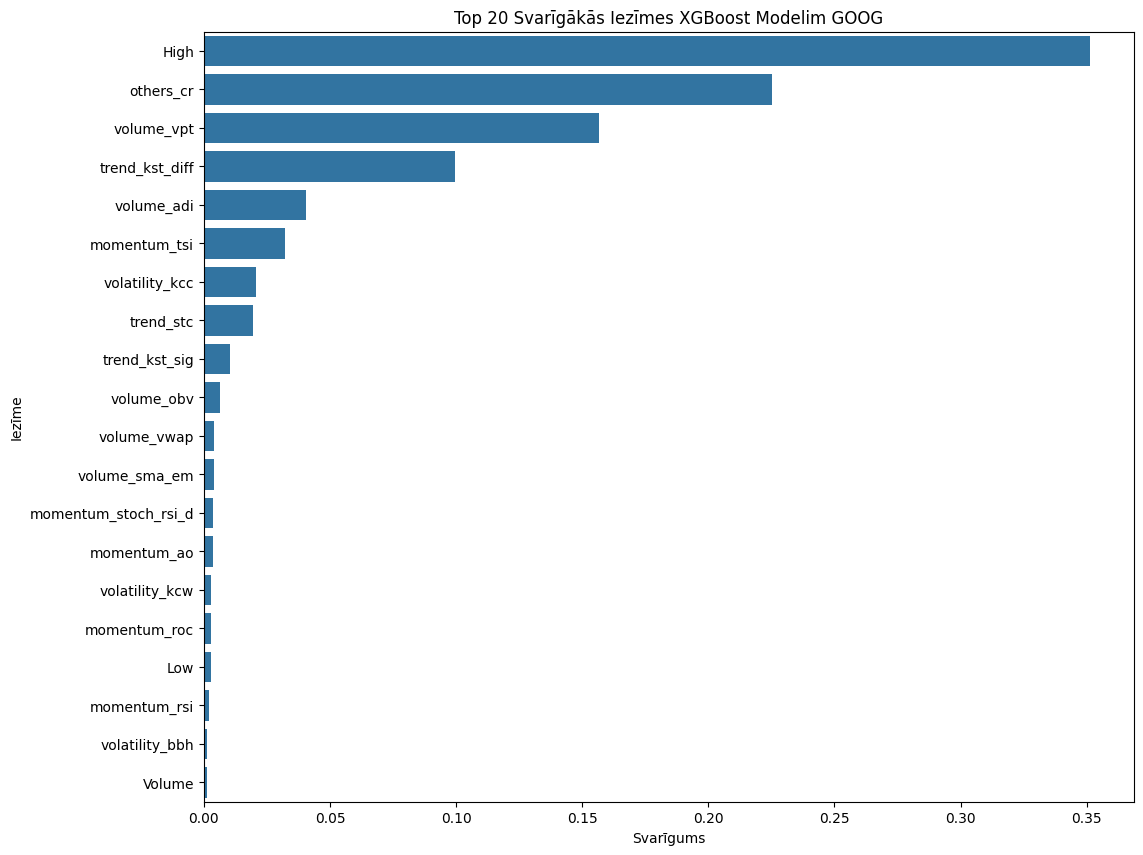

In [139]:
# Inicializē XGBoost modeļi ar norādītajiem parametriem
xgboost_model = XGBRegressor(learning_rate=0.2, max_depth=7, n_estimators=200)

# Apmaģina modeļi
xgboost_model.fit(X_train, y_train)

# Izvelk iezīmju svarīgumu
features = X_train.columns
importances = xgboost_model.feature_importances_

# Izveido DataFrame iezīmju svarīgumam
import pandas as pd
importances_df = pd.DataFrame({
    'Iezīme': features,
    'Svarīgums': importances
})

# Sakārto DataFrame pēc svarīguma dilstošā secībā un izvēlas top 20
top20_features = importances_df.sort_values(by='Svarīgums', ascending=False).head(20)

# Uzzīmē top 20 iezīmju diagrammu
plt.figure(figsize=(12, 10))
sns.barplot(x='Svarīgums', y='Iezīme', data=top20_features)
plt.title('Top 20 Svarīgākās Iezīmes XGBoost Modelim GOOG')
plt.xlabel('Svarīgums')
plt.ylabel('Iezīme')
plt.show()


In [90]:
results['GOOG']['AdaBoost']

({'learning_rate': 0.01, 'n_estimators': 100},
 11.353500046303227,
 0.734099434669981)

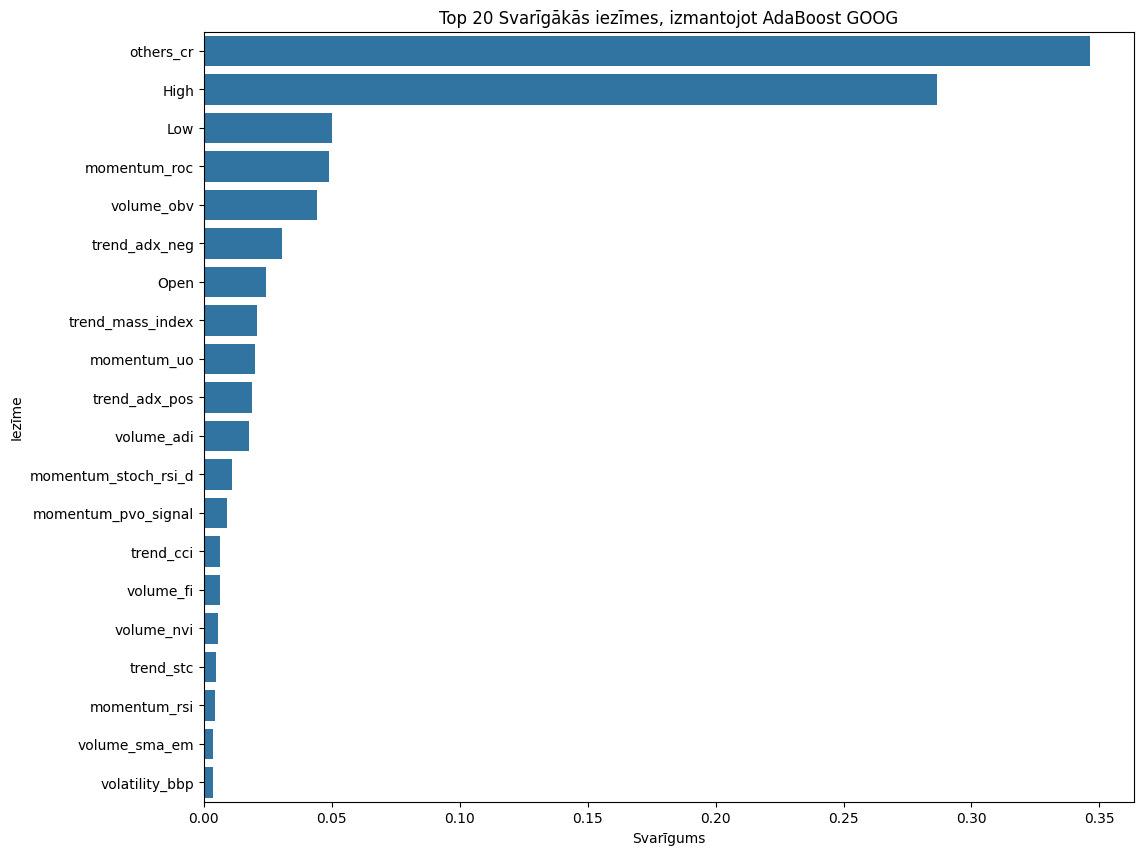

In [93]:
from sklearn.ensemble import AdaBoostRegressor

# Inicializē AdaBoost modeļi
adaboost_model = AdaBoostRegressor(n_estimators=100, learning_rate=0.1, loss='linear')

# Apmaģina modeļi
adaboost_model.fit(X_train, y_train)

# Izvelk iezīmju svarīgumu
importances = adaboost_model.feature_importances_

# Izveido DataFrame iezīmju svarīgumam
import pandas as pd
importances_df = pd.DataFrame({
    'Iezīme': features,
    'Svarīgums': importances
})

# Sakārto DataFrame pēc svarīguma dilstošā secībā
importances_df = importances_df.sort_values(by='Svarīgums', ascending=False)


# Izvelk tikai top 20 svarīgākās iezīmes
top20_features = importances_df.head(20)

# Uzzīmē svarīguma grafiku tikai ar top 20 iezīmēm
plt.figure(figsize=(12, 10))
sns.barplot(x='Svarīgums', y='Iezīme', data=top20_features)
plt.title('Top 20 Svarīgākās iezīmes, izmantojot AdaBoost GOOG')
plt.xlabel('Svarīgums')
plt.ylabel('Iezīme')
plt.show()


In [97]:
results['GOOG']['RandomForest']

({'max_features': 'sqrt', 'n_estimators': 100},
 11.192874702536704,
 0.7378613027758214)

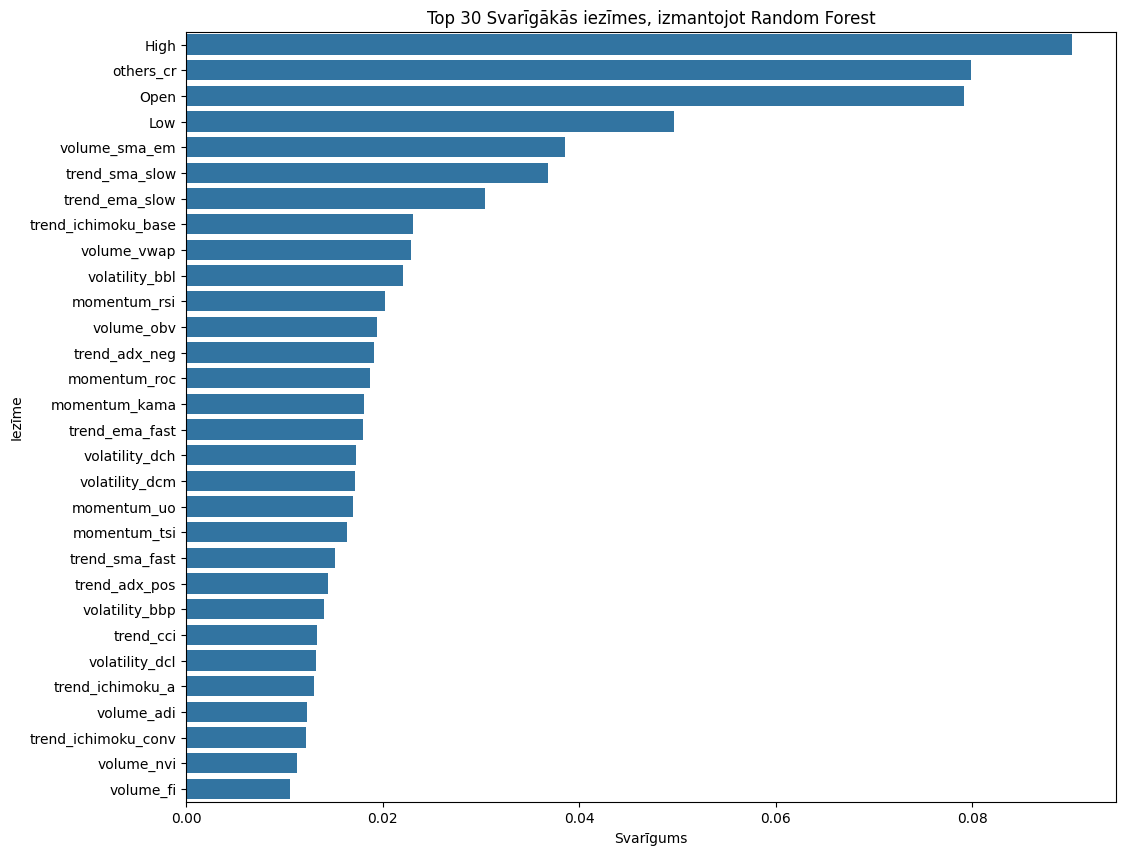

In [100]:
from sklearn.ensemble import RandomForestRegressor

# Inicializē Random Forest modeļi
random_forest_model = RandomForestRegressor(n_estimators=100, max_features='sqrt')

# Apmaģina modeļi
random_forest_model.fit(X_train, y_train)

# Izvelk iezīmju svarīgumu
importances = random_forest_model.feature_importances_

# Izveido DataFrame iezīmju svarīgumam
importances_df = pd.DataFrame({
    'Iezīme': features,
    'Svarīgums': importances
})

# Sakārto DataFrame pēc svarīguma dilstošā secībā
importances_df = importances_df.sort_values(by='Svarīgums', ascending=False)

# Izvelc tikai top 20 svarīgākās iezīmes
top20_features = importances_df.head(30)

# Uzzīmē svarīguma grafiku tikai ar top 20 iezīmēm
plt.figure(figsize=(12, 10))
sns.barplot(x='Svarīgums', y='Iezīme', data=top20_features)
plt.title('Top 30 Svarīgākās iezīmes, izmantojot Random Forest')
plt.xlabel('Svarīgums')
plt.ylabel('Iezīme')
plt.show()


### Metrics

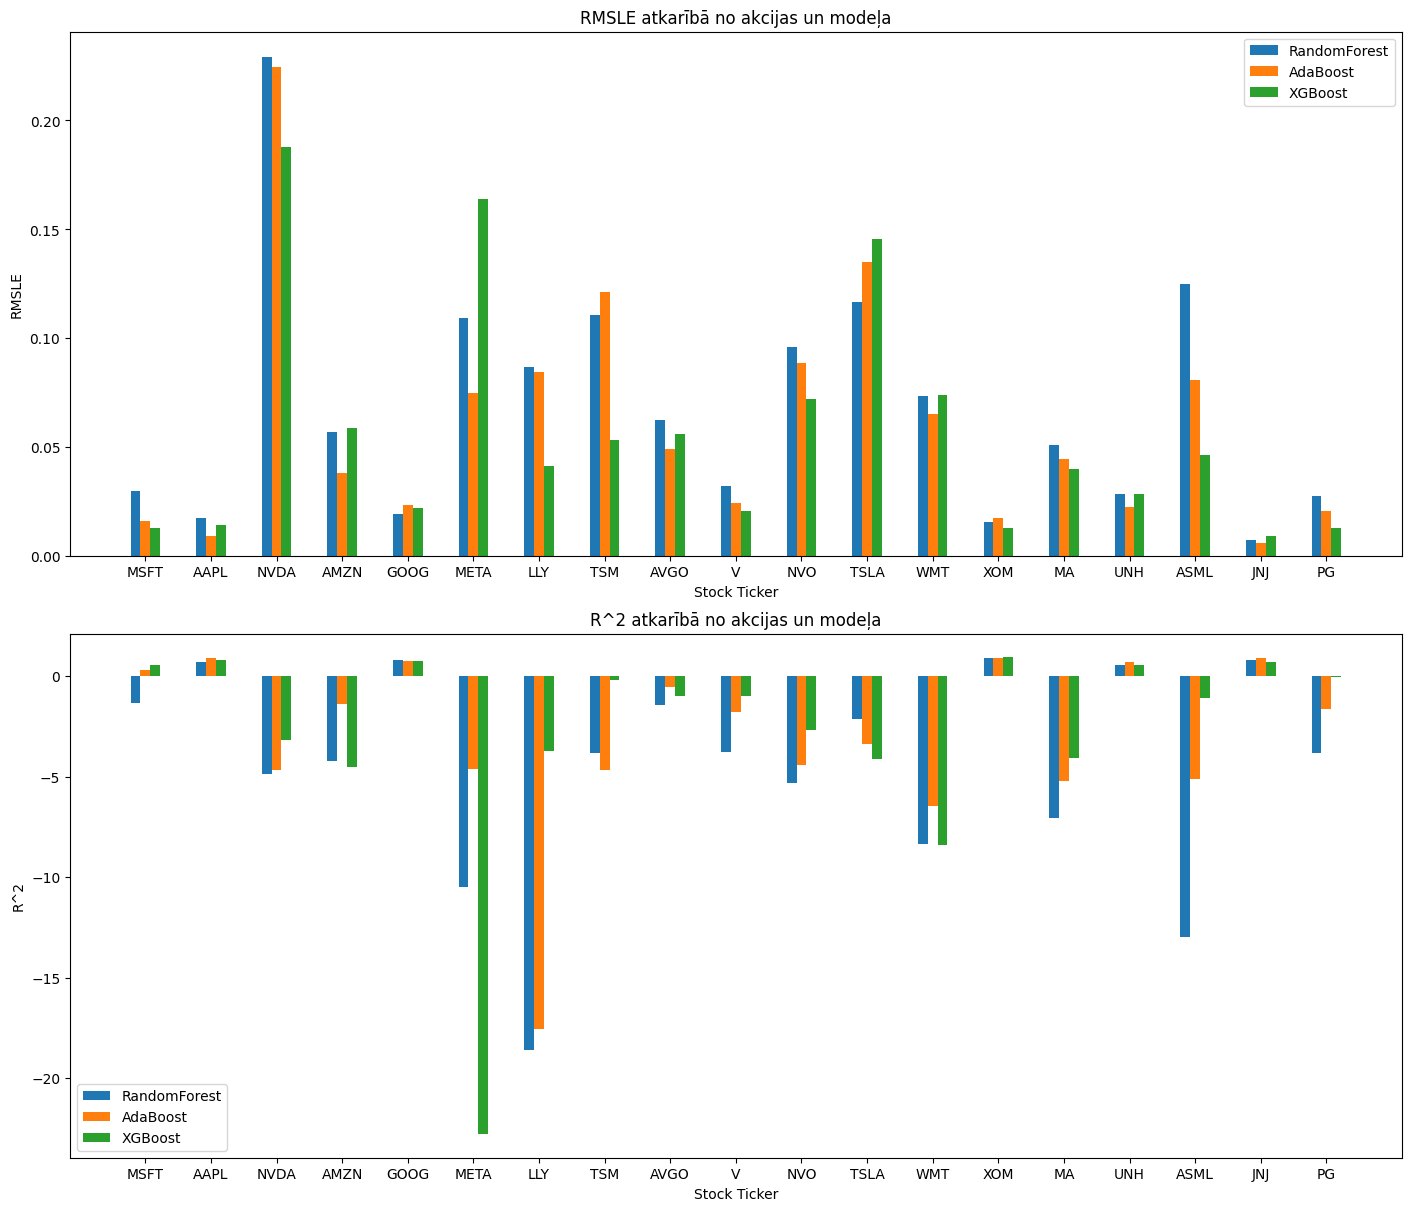

In [147]:
import matplotlib.pyplot as plt
import numpy as np

# Example data structure for 'results'
# results = {'AAPL': {'RandomForest': (best_params, RMSE, R^2), 'AdaBoost': (best_params, RMSE, R^2)}}

# Prepare the data for plotting
rmses = {model: [] for model in models}  # Use `models` directly if it's a dictionary
r2_scores = {model: [] for model in models}

# Populate the data structures with example data, assuming 'results' is filled with your real data
for ticker in COMPANIES:
    for model in models:
        if ticker in results and model in results[ticker]:  # Check if the ticker and model data is available
            rmses[model].append(results[ticker][model][1])  # Append RMSE
            r2_scores[model].append(results[ticker][model][2])  # Append R^2
        else:
            rmses[model].append(None)  # Append None if data for a model is missing
            r2_scores[model].append(None)

# Number of groups (stocks) and number of bars (models) per group
num_groups = len(COMPANIES)
num_bars = len(models)

# Position of bars on x-axis
bar_width = 0.15
indices = np.arange(num_groups)

# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12), constrained_layout=True)

# RMSE plot
for idx, (model, scores) in enumerate(rmses.items()):
    ax1.bar(indices + idx * bar_width, scores, bar_width, label=model)

ax1.set_xlabel('Stock Ticker')
ax1.set_ylabel('RMSLE')
ax1.set_title('RMSLE atkarībā no akcijas un modeļa')
ax1.set_xticks(indices + bar_width * (num_bars - 1) / 2)
ax1.set_xticklabels(COMPANIES)
ax1.legend()

# R^2 plot
for idx, (model, scores) in enumerate(r2_scores.items()):
    ax2.bar(indices + idx * bar_width, scores, bar_width, label=model)

ax2.set_xlabel('Stock Ticker')
ax2.set_ylabel('R^2')
ax2.set_title('R^2 atkarībā no akcijas un modeļa')
ax2.set_xticks(indices + bar_width * (num_bars - 1) / 2)
ax2.set_xticklabels(COMPANIES)
ax2.legend()

plt.show()


### Trading simulation

Diena 0: Signāls - Sell, Atvēršanas cena - 146.07, Slēgšanas cena - 149.54
   Portfeļa vērtība: 10000.00
Diena 1: Signāls - Buy, Atvēršanas cena - 147.37, Slēgšanas cena - 146.07
   Pirku 67 akcijas par 147.37, Kopējais akciju skaits: 67, Atlikušais kapitāls: 126.21
   Portfeļa vērtība: 9912.90
Diena 2: Signāls - Sell, Atvēršanas cena - 144.46, Slēgšanas cena - 147.37
   Pārdevu visas akcijas par 144.46, Akciju skaits: 0, Jaunais kapitāls: 9805.03
   Portfeļa vērtība: 9805.03
Diena 3: Signāls - Sell, Atvēršanas cena - 144.21, Slēgšanas cena - 144.46
   Portfeļa vērtība: 9805.03
Diena 4: Signāls - Sell, Atvēršanas cena - 140.94, Slēgšanas cena - 144.21
   Portfeļa vērtība: 9805.03
Diena 5: Signāls - Buy, Atvēršanas cena - 142.64, Slēgšanas cena - 140.94
   Pirku 68 akcijas par 142.64, Kopējais akciju skaits: 68, Atlikušais kapitāls: 105.51
   Portfeļa vērtība: 9689.43
Diena 6: Signāls - Buy, Atvēršanas cena - 146.12, Slēgšanas cena - 142.64
   Portfeļa vērtība: 9805.03
Diena 7: Signāls 

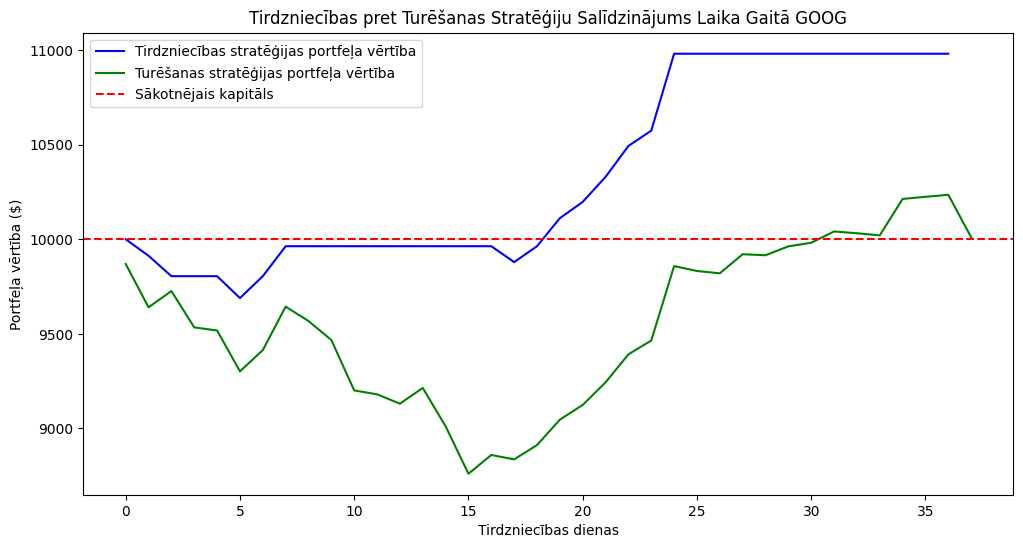

In [14]:
# Extract XGBoost parameters from results
xgb_params = results['GOOG']['XGBoost'][0]

# Initialize and train the XGBoost model
model = XGBRegressor(**xgb_params)
model.fit(X_train, y_train)

# Generate predictions for all available data
y_pred = model.predict(X_test)

# Shift predictions by one to align with the next day's opening price in 'df'
y_pred_shifted = np.roll(y_pred, -1)
y_pred_shifted = y_pred_shifted[:-1]  # Remove the last prediction as it has no next day

# Generate trading signals
signals = ['Buy' if pred > open else 'Sell' for pred, open in zip(y_pred_shifted, X_test['Open'])]

portfolio_value = []
# Initialize trading variables
initial_capital = 10000.00
capital = initial_capital
shares_owned = 0
portfolio_value = []

# Run the trading simulation
for i, (signal, actual_open, close) in enumerate(zip(signals, y_test, X_test['Open'])):
    actual_open = format(actual_open, ".2f")
    close = format(close, ".2f")
    print(f"Diena {i}: Signāls - {signal}, Atvēršanas cena - {actual_open}, Slēgšanas cena - {close}")

    if signal == 'Buy' and capital >= float(actual_open):
        shares_to_buy = int(capital // float(actual_open))
        capital -= shares_to_buy * float(actual_open)
        shares_owned += shares_to_buy
        print(f"   Pirku {shares_to_buy} akcijas par {actual_open}, Kopējais akciju skaits: {shares_owned}, Atlikušais kapitāls: {format(capital, '.2f')}")
    elif signal == 'Sell' and shares_owned > 0:
        capital += shares_owned * float(actual_open)
        shares_owned = 0
        print(f"   Pārdevu visas akcijas par {actual_open}, Akciju skaits: {shares_owned}, Jaunais kapitāls: {format(capital, '.2f')}")

    # Update the portfolio value based on current close prices
    portfolio_value.append(capital + shares_owned * float(close))
    print(f"   Portfeļa vērtība: {format(capital + shares_owned * float(close), '.2f')}")

# Finalize simulation
if shares_owned > 0:
    capital += shares_owned * float(y_test.iloc[-1])
    shares_owned = 0
    print(f"Simulācijas beigas: Pārdevu atlikušās akcijas par {format(y_test.iloc[-1], '.2f')}")

final_portfolio_value = capital
total_profit_loss = final_portfolio_value - initial_capital
total_return_percentage = ((final_portfolio_value - initial_capital) / initial_capital) * 100

print(f"Galīgā portfeļa vērtība: ${format(final_portfolio_value, '.2f')}")
print(f"Kopējā peļņa/zaudējumi: ${format(total_profit_loss, '.2f')}")
print(f"Kopējā atdeve procentos: {format(total_return_percentage, '.2f')}%")


# Uzzīmējam rezultātus
plt.figure(figsize=(12, 6))
plt.plot(portfolio_value, label='Tirdzniecības stratēģijas portfeļa vērtība', color='blue')
plt.plot(hold_portfolio_value, label='Turēšanas stratēģijas portfeļa vērtība', color='green')
plt.axhline(y=initial_capital, color='red', linestyle='--', label='Sākotnējais kapitāls')
plt.title('Tirdzniecības pret Turēšanas Stratēģiju Salīdzinājums Laika Gaitā GOOG')
plt.xlabel('Tirdzniecības dienas')
plt.ylabel('Portfeļa vērtība ($)')  # Pievērsiet uzmanību valūtas apzīmējumam
plt.legend()
plt.show()


### Simulation on all stocks

In [150]:
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor


def perform_trading_simulation(ticker, model_results, X_train, X_test, y_train, y_test):
    # Extract XGBoost parameters from results
    model_params = model_results['XGBoost'][0]
    # model_params = model_results['AdaBoost'][0]
    # model_params = model_results['RandomForest'][0]

    # Initialize and train the XGBoost model
    # model = AdaBoostRegressor(**model_params)
    # model = RandomForestRegressor(**model_params)
    model = XGBRegressor(**model_params)

    model.fit(X_train, y_train)

    # Generate predictions for all available data
    y_pred = model.predict(X_test)

    # Shift predictions by one to align with the next day's opening price in 'df'
    y_pred_shifted = np.roll(y_pred, -1)
    y_pred_shifted = y_pred_shifted[:-1]  # Remove the last prediction as it has no next day

    # Generate trading signals
    signals = ['Buy' if pred > open else 'Sell' for pred, open in zip(y_pred_shifted, X_test['Open'])]

    # Simulate trading
    initial_capital = 10000.00
    capital = initial_capital
    shares_owned = 0
    portfolio_value = []

    for i, (signal, actual_open, close) in enumerate(zip(signals, y_test, X_test['Open'])):
        if signal == 'Buy' and capital >= actual_open:
            shares_to_buy = int(capital // actual_open)
            capital -= shares_to_buy * actual_open
            shares_owned += shares_to_buy
        elif signal == 'Sell' and shares_owned > 0:
            capital += shares_owned * actual_open
            shares_owned = 0
        # Update the portfolio value based on current close prices
        portfolio_value.append(capital + shares_owned * close)

    # Finalize simulation
    if shares_owned > 0:
        capital += shares_owned * y_test.iloc[-1]
        shares_owned = 0

    # Calculate total return percentage for holding strategy
    stock_initial_price = X_test['Open'].iloc[0]
    stock_final_price = y_test.iloc[-1]
    shares_bought = initial_capital // stock_initial_price
    hold_final_value = shares_bought * stock_final_price
    hold_portfolio_value = [shares_bought * price for price in X_test['Open']]
    holding_return_percentage = ((hold_final_value - initial_capital) / initial_capital) * 100

    # Calculate portfolio value percentage change
    portfolio_value_percentage_change = ((portfolio_value[-1] - initial_capital) / initial_capital) * 100

    return capital, portfolio_value, hold_portfolio_value, holding_return_percentage, portfolio_value_percentage_change


# Define a dictionary to store results for each ticker
all_results = {}

# Iterate over each ticker in the results dictionary
for ticker, model_results in results.items():
 # Define the path to your file using the ticker variable
    file_path = f'Data/{ticker}_historical_data.csv'
    # Read the CSV file into a DataFrame
    df_prices = pd.read_csv(file_path)

    # Initialize lists to store data from all files
    all_dates, all_sentiment_scores, all_relevance_scores, all_avg_relevance_scores = [], [], [], []

    # List all JSON files in the directory corresponding to the ticker
    json_files = [file for file in os.listdir('Data') if file.startswith(f'{ticker}_news_data') and file.endswith('.json')]

    # Iterate over each JSON file
    for file in json_files:
        with open(os.path.join('Data', file), 'r', encoding='utf-8') as file:
            data = json.load(file)
            news_feed = data['feed']
        
        # Iterate over the news feed in each file to extract information
        for item in news_feed:
            ticker_info = [ts for ts in item['ticker_sentiment'] if ts['ticker'] == ticker]
            if ticker_info:  # Check if info is available in the ticker sentiment
                all_dates.append(item['time_published'])
                all_sentiment_scores.append(ticker_info[0]['ticker_sentiment_score'])
                all_relevance_scores.append(ticker_info[0]['relevance_score'])
                # Calculate the average relevance score for all tickers in the news item
                avg_relevance = sum(float(ts['relevance_score']) for ts in item['ticker_sentiment']) / len(item['ticker_sentiment'])
                all_avg_relevance_scores.append(avg_relevance)

        # Print length of lists after each file
        print(f"File: {file}, Entries: {len(all_dates)}")

    # Create a DataFrame from the collected data
    df = pd.DataFrame({
        'Date': all_dates,
        'Sentiment_Score': all_sentiment_scores,
        'Relevance_Score_ticker': all_relevance_scores,
        'Avg_Relevance_Score_topics': all_avg_relevance_scores
    })

    # Convert 'Date' column to datetime
    df['Date'] = pd.to_datetime(df['Date']).dt.normalize()

    # Convert relevant columns to float
    df['Sentiment_Score'] = df['Sentiment_Score'].astype(float)
    df['Relevance_Score_ticker'] = df['Relevance_Score_ticker'].astype(float)
    df['Avg_Relevance_Score_topics'] = df['Avg_Relevance_Score_topics'].astype(float)

    # Group by 'Date' and calculate mean, min, and max for 'Sentiment_Score'
    df_grouped = df.groupby('Date').agg({
        'Sentiment_Score': ['mean', 'min', 'max'],
        'Relevance_Score_ticker': 'mean',
        'Avg_Relevance_Score_topics': 'mean'
    }).reset_index()

    # Flatten multi-index columns
    df_grouped.columns = ['Date', 'Sentiment_Score_mean', 'Sentiment_Score_min', 'Sentiment_Score_max',
                        'Relevance_Score_ticker_mean', 'Avg_Relevance_Score_topics_mean']

    # Ensure df_grouped is loaded and has the necessary columns converted to datetime if not already done
    df_grouped['Date'] = pd.to_datetime(df_grouped['Date'])
    df_grouped.set_index('Date', inplace=True)

    # Create a date range from start date to end date
    date_range = pd.date_range(start='2023-08-31', end='2024-04-07', freq='D')

    # Reindex the DataFrame to include all dates in the range
    df_grouped = df_grouped.reindex(date_range)

    # Use backward fill to fill initial missing values, then forward fill the rest
    df_grouped.bfill(inplace=True)
    df_grouped.ffill(inplace=True)

    # Resetting index to turn 'Date' back into a column
    df_grouped.reset_index(inplace=True)
    df_grouped.rename(columns={'index': 'Date'}, inplace=True)

    df_prices['Date'] = df_prices['Date'].astype(str)
    # Slice the string to extract only the date part
    df_prices['Date'] = df_prices['Date'].str[0:10]
    # Convert back to datetime
    df_prices['Date'] = pd.to_datetime(df_prices['Date'])
    # Merge the data on 'Date'
    df1 = pd.merge(df_grouped, df_prices[['Date', 'Close', 'Open', 'Volume', 'Low', 'High']], on='Date', how='right')
    df = df1
    df['Next_Day_Open'] = df['Open'].shift(-1)
    df.dropna(subset='Next_Day_Open', inplace=True)
    df = df[df.Date <= '2024-04-05']
    ### Social meadia - Reddit sentiment
    df_reddit_raw = pd.read_csv("Reddit_sentiment_grouped.csv")
    df_reddit = df_reddit_raw
    df_reddit['Date'] = pd.to_datetime(df_reddit['Date'])

    # Find the global min and max dates across all tickers
    global_start_date = df_reddit['Date'].min()
    global_end_date = df_reddit['Date'].max()

    # Create an empty DataFrame to store results
    result_df = pd.DataFrame()

    # Process each ticker group separately
    for ticker_reddit, group in df_reddit.groupby('Ticker'):
        # Create date range from the global earliest to the global latest date
        date_range = pd.date_range(start=global_start_date, end=global_end_date, freq='D')
        
        # Reindex the group to include all days in the range, setting Date as the index
        group.set_index('Date', inplace=True)
        group_reindexed = group.reindex(date_range, method='ffill')  # Ensure forward fill is called here

        # Reset the index to turn the date index back into a column
        group_reindexed.reset_index(inplace=True)
        group_reindexed.rename(columns={'index': 'Date'}, inplace=True)

        # Set the Ticker for all rows in the reindexed DataFrame
        group_reindexed['Ticker'] = ticker_reddit
        
        # Concatenate this reindexed group to the result DataFrame
        result_df = pd.concat([result_df, group_reindexed], ignore_index=True)
        
    result_df = result_df[result_df.Ticker == ticker]
    df = df.merge(result_df.drop(columns={'Ticker'}), on = 'Date', how = 'left')
    full_ta = add_all_ta_features(
        df, open="Open", high="High", low="Low", close="Close", volume="Volume"
    )
    df = df.dropna(subset=['Next_Day_Open','Sentiment_Score_mean'])
    null_percentage = df.isnull().mean() * 100

    # Sort the percentages in descending order
    sorted_null_percentage = null_percentage.sort_values(ascending=False)

    # # Display the sorted percentages
    # print(sorted_null_percentage)
    # Drop
    df = df.dropna(axis=1, how='any')
    X = df.drop(columns=['Next_Day_Open','Close','Date'])
    y = df['Next_Day_Open']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)
    # Perform trading simulation for the ticker
    capital, portfolio_value, hold_portfolio_value, holding_return_percentage, portfolio_value_percentage_change = perform_trading_simulation(ticker, model_results, X_train, X_test, y_train, y_test)
    del df
    # Store the results for the ticker
    all_results[ticker] = {
        'Capital': capital,
        'Portfolio_Value': portfolio_value,
        'Holding_Portfolio_Value': hold_portfolio_value,
        'Holding_Return_Percentage': holding_return_percentage,
        'Portfolio_Value_Percentage_Change': portfolio_value_percentage_change
    }

File: <_io.TextIOWrapper name='Data\\MSFT_news_data.json' mode='r' encoding='utf-8'>, Entries: 712
File: <_io.TextIOWrapper name='Data\\MSFT_news_data_20230831_20230930.json' mode='r' encoding='utf-8'>, Entries: 1422
File: <_io.TextIOWrapper name='Data\\MSFT_news_data_20230901_20231001.json' mode='r' encoding='utf-8'>, Entries: 2132
File: <_io.TextIOWrapper name='Data\\MSFT_news_data_20231002_20231102.json' mode='r' encoding='utf-8'>, Entries: 2827
File: <_io.TextIOWrapper name='Data\\MSFT_news_data_20231103_20231203.json' mode='r' encoding='utf-8'>, Entries: 3542
File: <_io.TextIOWrapper name='Data\\MSFT_news_data_20231204_20240104.json' mode='r' encoding='utf-8'>, Entries: 4247
File: <_io.TextIOWrapper name='Data\\MSFT_news_data_20240105_20240205.json' mode='r' encoding='utf-8'>, Entries: 4938
File: <_io.TextIOWrapper name='Data\\MSFT_news_data_20240206_20240307.json' mode='r' encoding='utf-8'>, Entries: 5651
File: <_io.TextIOWrapper name='Data\\AAPL_news_data.json' mode='r' encoding

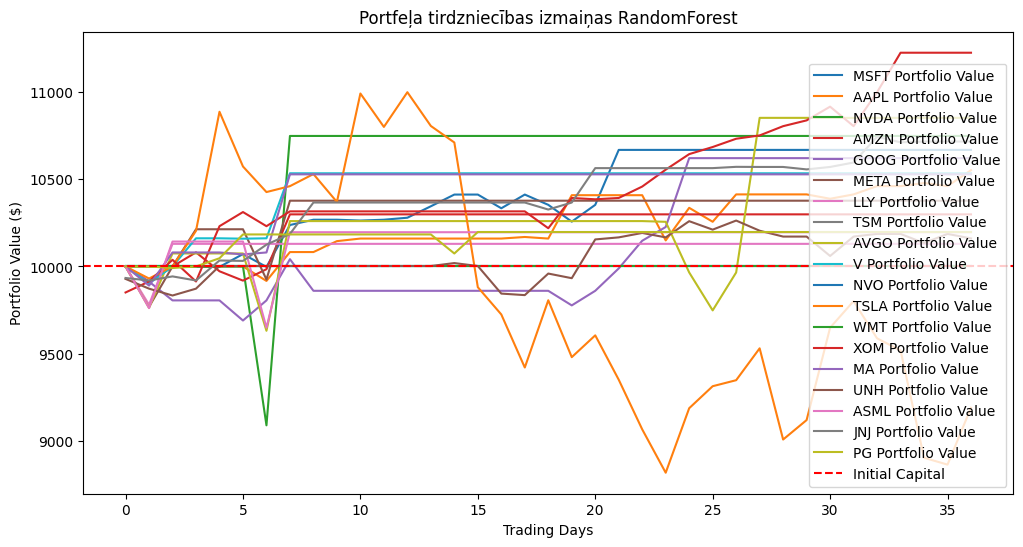

In [118]:
# Visualize the results for all tickers
plt.figure(figsize=(12, 6))
for ticker, data in all_results.items():
    plt.plot(data['Portfolio_Value'], label=f'{ticker} Portfolio Value')

plt.axhline(y=initial_capital, color='red', linestyle='--', label='Initial Capital')
plt.title('Portfeļa tirdzniecības izmaiņas RandomForest')
plt.xlabel('Trading Days')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.show()

In [152]:
# Izveidojam DataFrame
df_returns_compared = pd.DataFrame.from_dict(all_results)

# Pārveidojam DataFrame, lai iegūtu tikai 'MSFT' un visus pārējos akciju zīmolus
df_returns_compared = df_returns_compared.transpose()

In [153]:
df_returns_compared.drop(columns={'Capital','Portfolio_Value','Holding_Portfolio_Value'}, inplace=True)

In [154]:
df_returns_compared.Holding_Return_Percentage.mean()

1.2626106222225493

In [155]:
df_returns_compared.Portfolio_Value_Percentage_Change.mean()

3.9939658649172323

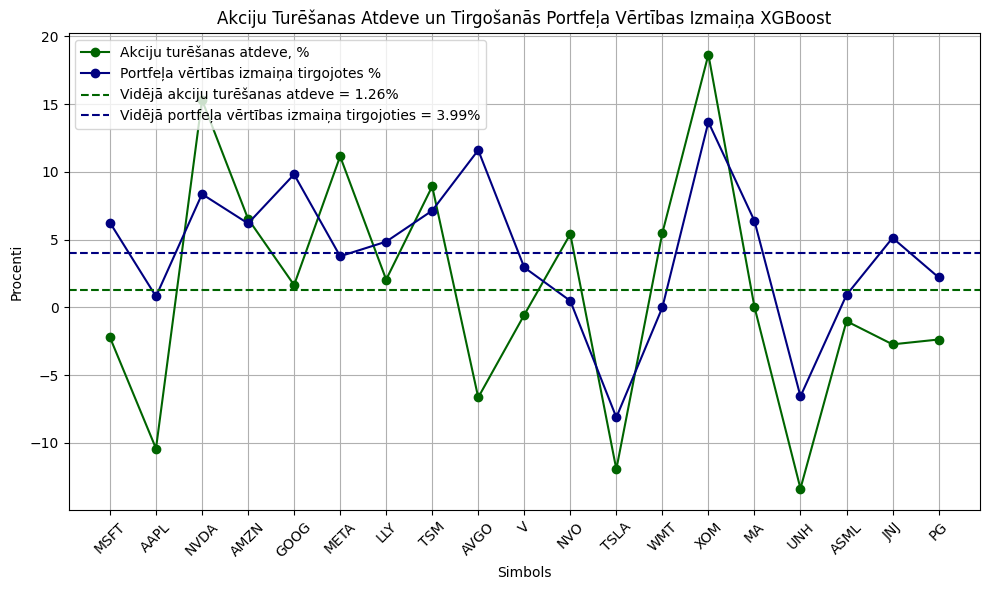

In [156]:
import matplotlib.pyplot as plt

# Izveidojam grafiku
plt.figure(figsize=(10, 6))

# Definējam krāsas
holding_color = 'darkgreen'
portfolio_change_color = 'navy'

# Līnijas
plt.plot(df_returns_compared.index, df_returns_compared['Holding_Return_Percentage'], marker='o', color=holding_color, label='Akciju turēšanas atdeve, %')
plt.plot(df_returns_compared.index, df_returns_compared['Portfolio_Value_Percentage_Change'], marker='o', color=portfolio_change_color, label='Portfeļa vērtības izmaiņa tirgojotes %')

# Vidējā vērtība līnija un tās vērtība
avg_holding_return_percentage = df_returns_compared['Holding_Return_Percentage'].mean()
avg_portfolio_value_percentage_change = df_returns_compared['Portfolio_Value_Percentage_Change'].mean()

# Uzliekam vidējo vērtību līnijas ar reālajām vērtībām uz tām
plt.axhline(y=avg_holding_return_percentage, color=holding_color, linestyle='--', label=f'Vidējā akciju turēšanas atdeve = {avg_holding_return_percentage:.2f}%')
plt.axhline(y=avg_portfolio_value_percentage_change, color=portfolio_change_color, linestyle='--', label=f'Vidējā portfeļa vērtības izmaiņa tirgojoties = {avg_portfolio_value_percentage_change:.2f}%')

# Nosaukumi un leģenda
plt.title('Akciju Turēšanas Atdeve un Tirgošanās Portfeļa Vērtības Izmaiņa XGBoost')
plt.xlabel('Simbols')
plt.ylabel('Procenti')
plt.legend()

# Izvadam grafiku
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()
